In [2]:
!pip install simpful

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from simpful import *

def create_fuzzy_variable(num_regions: int,
                        value_range: list) -> simpful.AutoTriangle:
    """
    This function automatically creates fuzzy variables with their defined regions.

    Args:
        - num_regions: Number of regions for the fuzzy variable
        - value_range: List containing the minimum and maximum values of the variable
    Returns:
        - var: Fuzzy variable with its regions defined
    """
    # Inicialization of the variables
    regions = 2 * num_regions + 1
    universe_of_discourse = [min(value_range), max(value_range)]

    # Creating of the regions
    regions_name = []
    for i in range(regions):
        regions_name.append(f"S{abs(i - num_regions)}" if i < num_regions else f"B{abs(i - num_regions)}" if i > num_regions else "Z")
    var = AutoTriangle(regions, terms=regions_name, universe_of_discourse=universe_of_discourse)

    return var

def strong_pertinence(var: simpful.AutoTriangle,
                      value:float) -> tuple[str, float]:
    """
    Determine the strongest pertinence region considering the value

    Args:
        - var: fuzzy variable
        - value: the test value
    Return
        - strong_term: the strongest term
        - value_term: the pertinence level
    """
    # Inicialization variables
    terms_list = []
    value_list = []

    # Calculation of highest pertinence
    for term, value in var.get_values(value).items():
        terms_list.append(term)
        value_list.append(value)
    strong_term = terms_list[np.argmax(value_list)]
    value_term = value_list[np.argmax(value_list)]
    # strong_term = max(var.get_values(value), key= var.get_values(value).get)
    # value_term = var.get_values(value)[strong_term]
    return strong_term, value_term

def build_rule(inputs:list, output:list, terms:list, var_names:list) -> str:
    """
    Rule string creation to taylor with the simpful lib

    Args:
        - inputs: list of fuzzy variables of input
        - terms: list of the strongest terms for each fuzzy variable (inputs and outputs)
    Return:
        - rule_string: the rule string
    """
    rule_string =  "IF "
    for i in range(len(inputs)):
        rule_string += f"({var_names[i]} IS {terms[i]}) AND "
    rule_string = rule_string[:-4] + f"THEN ({var_names[-1]} IS {terms[-1]})"
    return rule_string

def rules_database(inputs: list,
                   output: list,
                   values_io: list,
                   var_names:list,
                   rules: list=None,
                   weights: list=None) ->  tuple[list, list]:
    """
    This function build or append rules to the rules_database.

    Args:
        - inputs: The fuzzy input variables
        - output: The fuzzy output variables
        - values_io: List of values for each variable
        - rules: The set of rule
        - weights: The set of rules' weights.
    Returns:
        - rules
        - weights
    """
    # Inicialization of some variables
    rules = [] if rules is None else rules
    weights = [] if weights is None else weights
    terms_list = []
    weight_list = []

    # Join all vars inside an list
    fuzzy_vars = inputs.copy()
    fuzzy_vars.append(output[0])

    """ PASSO 2 """
    # Calculate the strogest pertinence considering the values_io
    for i in range(len(fuzzy_vars)):
        term, weight = strong_pertinence(fuzzy_vars[i], values_io[i])
        terms_list.append(term)
        weight_list.append(weight)

    """ PASSO 3 """
    # Rule creation and rules' weight calculation
    new_weight = reduce(lambda x, y: x * y, weight_list)
    new_rule = build_rule(inputs, output, terms_list,var_names)

    """ PASSO 4 """
    # If the rule is new, just add it to the rules' database
    if not any(new_rule[:new_rule.find('THEN')] in item for item in rules) or len(rules) == 0:
        rules.append(new_rule)
        weights.append(new_weight)
    # Else, if the rule is already in the database, add it if the new weight is higher than the old one
    else:
        arr = np.array(rules)
        mask = np.core.defchararray.find(arr.astype(str), new_rule[:new_rule.find('THEN')])
        old_weight = weights[mask[0]]
        if new_weight > old_weight:
            rules[mask[0]] = new_rule
            weights[mask[0]] = new_weight
    return rules, weights

def rules_compact(rules):
    rule_output = set()
    for i in rules:
        rule_output.add(i[i.find("THEN"):])
    rule_output = list(rule_output)
    rule_compact = []

    for item_output in rule_output:
        string_compact = "IF ("
        indices = []
        for i, item in enumerate(rules):
            if item_output in item:
                indices.append(i)

        for j in range(len(indices)):
            comb_ini = rules[indices[j]].find("IF (")+3
            comb_end = rules[indices[j]].find("THEN")-1
            string_compact+=rules[indices[j]][comb_ini:comb_end]
            string_compact+=") OR ("
            if j == len(indices)-1:
                string_compact=string_compact[:-5]
                string_compact+=" "+item_output
        rule_compact.append(string_compact)

    return rule_compact

### Creating the Sin Function
___

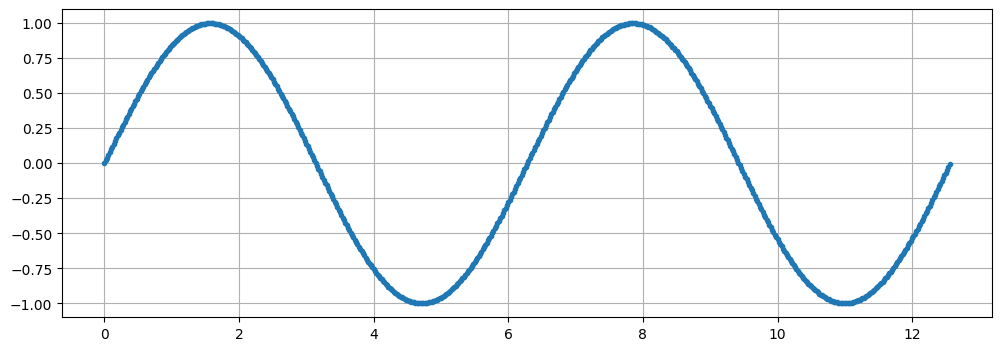

In [5]:
pi = np.pi
t = np.arange(0,4*pi,0.02)
y = np.sin(t)
plt.figure(figsize=(12,4))
plt.plot(t,y, marker='.', ls='')
plt.grid()

In [6]:
x1 = np.roll(y, 1)
x2 = np.roll(y, 2)
x3 = np.roll(y, 3)

x1, x2, x3,  y = x1[3:], x2[3:], x3[3:], y[3:]
x1t, x2t, x3t, yt = x1[:int(len(t)*0.7)], x2[:int(len(t)*0.7)], x3[:int(len(t)*0.7)], y[:int(len(t)*0.7)]
x1v, x2v, x3v, yv = x1[int(len(t)*0.7):], x2[int(len(t)*0.7):], x3[int(len(t)*0.7):] ,y[int(len(t)*0.7):]

In [12]:
print(y[:5])
print(x1[:5])
print(x2[:5])
print(x3[:5])

[0.05996401 0.07991469 0.09983342 0.11971221 0.13954311]
[0.03998933 0.05996401 0.07991469 0.09983342 0.11971221]
[0.01999867 0.03998933 0.05996401 0.07991469 0.09983342]
[0.         0.01999867 0.03998933 0.05996401 0.07991469]


### Passo 1: Criação dos conjuntos fuzzy
___

In [40]:
N=7
min_max = [-1.5, 1.5]
var_names = ["var1", "var2", "var3", "out"]

var1 = create_fuzzy_variable(N, min_max)
var2 = create_fuzzy_variable(N, min_max)
var3 = create_fuzzy_variable(N, min_max)
out = create_fuzzy_variable(N, min_max)


In [41]:
for term, value in var1.get_values(0.5).items():
          print(term)
          print(value)

S7
0
S6
0
S5
0
S4
0
S3
0
S2
0
S1
0
Z
0
B1
0
B2
0.6666666666666674
B3
0.3333333333333326
B4
0
B5
0
B6
0
B7
0


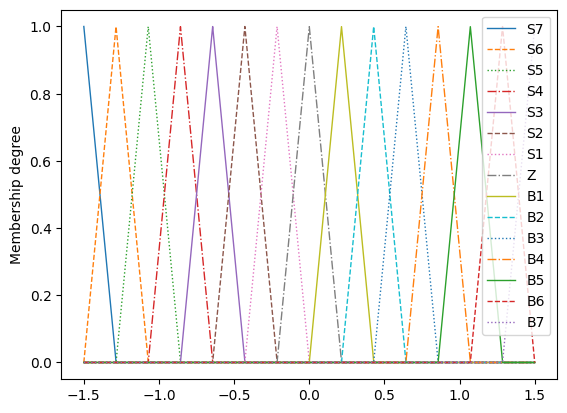

In [42]:
var1.plot()

### Passo 2, Passo 3 e Passo 4: Regras automáticas
___

In [43]:
# Vars
inputs = [var1, var2, var3]
output = [out]
vars_fuzzy = inputs+output
rules_acc = []
weights = []

# Treinando fuzzy
for i in range(len(yt)):
    values_io = [x1t[i],x2t[i],x3t[i],yt[i]]
    rules_acc, weights, = rules_database(inputs, output, values_io, var_names, rules_acc, weights)
rules_acc[:5]

['IF (var1 IS Z) AND (var2 IS Z) AND (var3 IS Z) THEN (out IS Z)',
 'IF (var1 IS B1) AND (var2 IS Z) AND (var3 IS Z) THEN (out IS B1)',
 'IF (var1 IS B1) AND (var2 IS B1) AND (var3 IS Z) THEN (out IS B1)',
 'IF (var1 IS B1) AND (var2 IS B1) AND (var3 IS B1) THEN (out IS B1)',
 'IF (var1 IS B2) AND (var2 IS B1) AND (var3 IS B1) THEN (out IS B2)']

In [44]:
len(rules_acc)

53

### Saving the rules in the fuzzy database
___

In [45]:
FS = FuzzySystem(show_banner=False)

for i in range(len(vars_fuzzy)):
    FS.add_linguistic_variable(var_names[i], vars_fuzzy[i])
FS.add_rules(rules_acc)

### Validation phase
___

In [46]:
y_predict1 = []
for i in range(len(yv)):
    FS.set_variable("var1", x1v[i])
    FS.set_variable("var2", x2v[i])
    FS.set_variable("var3", x3v[i])
    y_predict1.append(FS.Mamdani_inference()['out'])

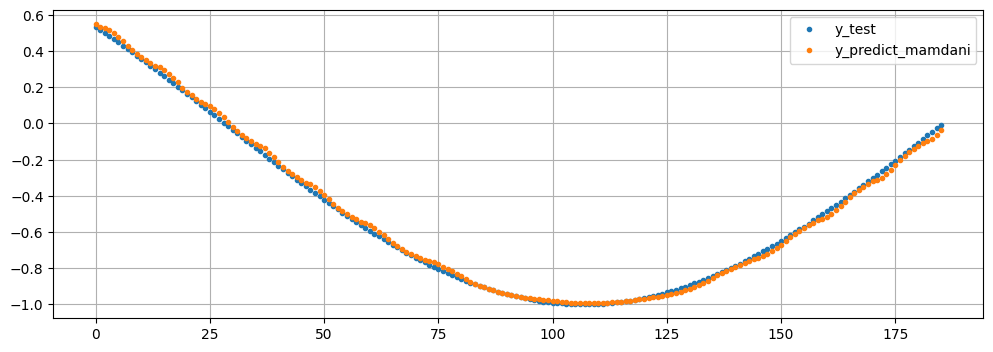

In [47]:
plt.figure(figsize=(12,4))
plt.plot(yv, ls = '', marker = '.', label="y_test")
plt.plot(y_predict1, ls = '', marker = '.', label="y_predict_mamdani")

plt.grid()
plt.legend()